# Titanic dataset exploration

In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
titanic = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')

### Exploring features

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Searching for lack of information about passengers

In [5]:
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Some stats comparing survived to non-survived people

,Yes,No
Survived,549,342


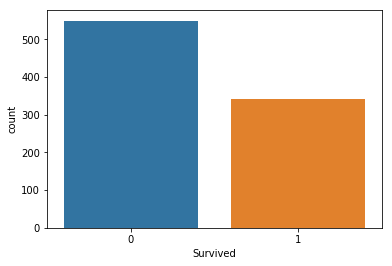

In [6]:
sns.countplot(titanic['Survived']);
pd.DataFrame(list(titanic.Survived.value_counts()), index=['Yes', 'No'], columns=['Survived']).T

#### Exploring relation between sex and survival of passengers
Male passengers are, at least, four times more likely to die.

Female passengers are two times more likely to survive.

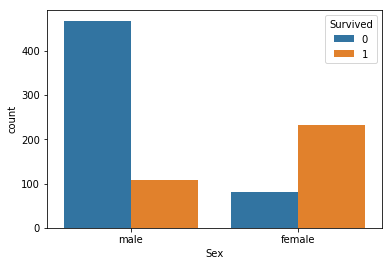

In [7]:
sns.countplot(titanic['Sex'], hue=titanic['Survived']);

#### Relation between the travelling class and survival
Class 3 are much more likely to die than survive.

Class 2 have about the same chances for both.

Class 1 are a little bit more likely to survive.

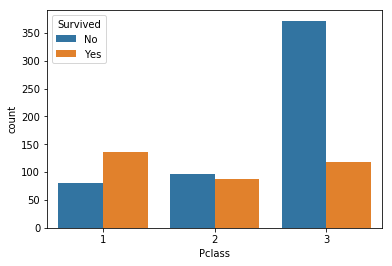

In [8]:
survived_annotated = titanic['Survived'].replace({1:'Yes', 0: 'No'})
sns.countplot(titanic['Pclass'], hue=survived_annotated);

#### Exploring correlation between age, fare, class and survival
No obvious correlation found.

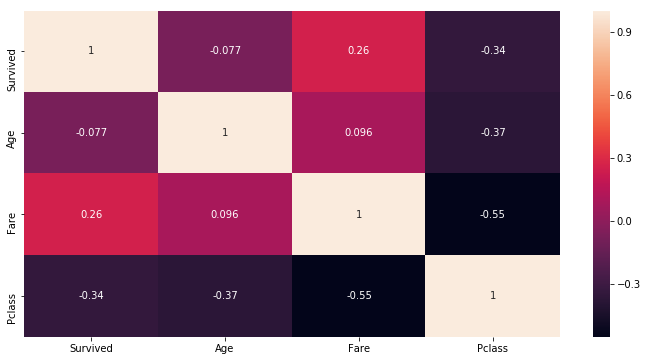

In [9]:
correlation = titanic[['Survived', 'Age', 'Fare', 'Pclass']].corr()

plt.figure(figsize=(12,6))
sns.heatmap(correlation, annot=True);

#### Viewing a sample of the people on board

In [10]:
titanic.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
585,0,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
828,1,2,"Mallet, Master. Andre",male,1.0,0,2,S.C./PARIS 2079,37.0042,NaN,C
263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,S
36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S
874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S
445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S
290,1,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
686,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C


#### Extracting the title of passengers
Each passenger has a title in front of its name.

In [11]:
titanic['Title'] = titanic['Name'].str.extract('^.*, (.*?)\. .*$', expand = False)

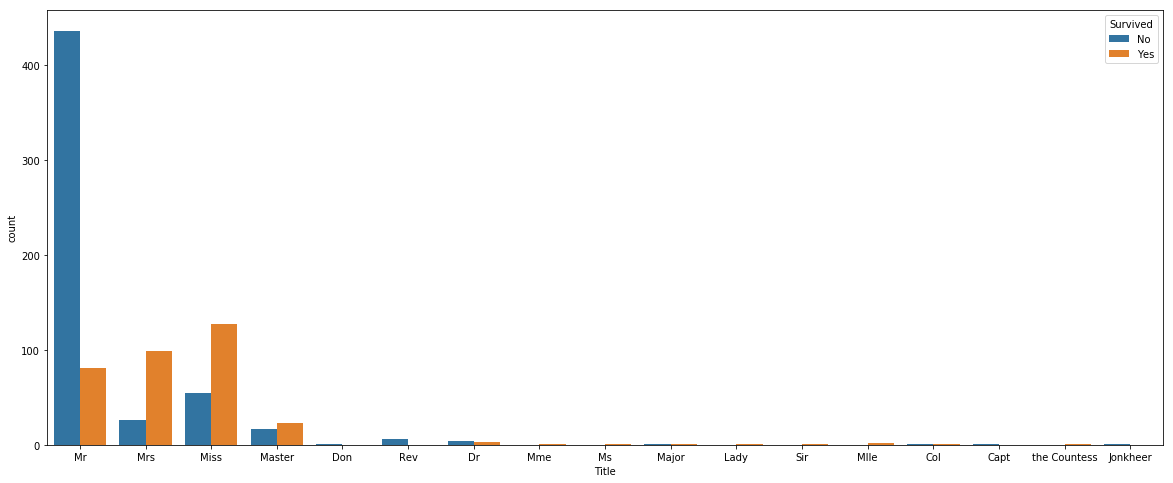

In [12]:
plt.figure(figsize=(20,8))
sns.countplot(x=titanic.Title, hue=survived_annotated);

Some titles have too few occurrences and others are from other languages than english (e.g. Don, Mmme...), so we will aggregate them to fewer and more populated features.

In [13]:
titles_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Rev",
    "the Countess": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}    
titanic["Title"] = titanic["Title"].apply(titles_dict.get)

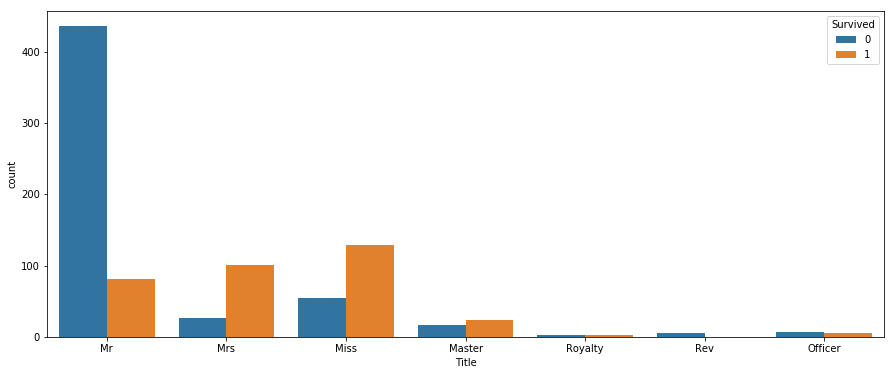

In [14]:
plt.figure(figsize=(15,6))
sns.countplot('Title', hue='Survived', data=titanic);

Also, based on the mean age of each title, we can restore the age of the people, that don't have any in the dataset. 

In [15]:
age_by_title = titanic.groupby('Title').Age.mean()
age_by_title

Title
Master      4.574167
Miss       21.804054
Mr         32.368090
Mrs        35.718182
Officer    48.636364
Rev        43.166667
Royalty    41.600000
Name: Age, dtype: float64

In [16]:
def restore_age(title, age):
    titanic.loc[titanic.Age.isnull() & (titanic.Title == title), 'Age'] = age[title]

for title in set(titanic.Title):
    restore_age(title, age_by_title)

Age is now filled

In [17]:
sum(pd.isna(titanic.Age))

0

#### Create features for each title

In [18]:
def create_title_feature(title):
    titanic['Is' + title]      = (titanic.Title == title).astype(float)

for title in set(titanic.Title):
    create_title_feature(title)

In [19]:
import re
[ x for x in titanic.columns if re.match(r'^Is.*', x) ]

['IsMiss', 'IsMaster', 'IsRev', 'IsRoyalty', 'IsOfficer', 'IsMr', 'IsMrs']

Add a feature if a passenger is a kid, because adults have much bigger chance to die than kids.

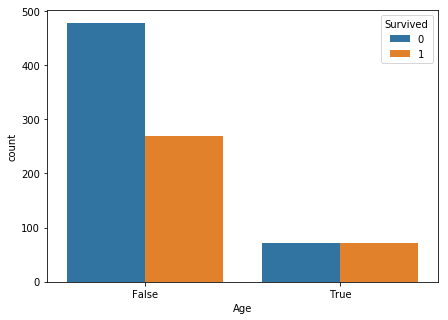

In [20]:
plt.figure(figsize=(7,5))
sns.countplot(titanic.Age <= 18, hue=titanic.Survived);
titanic['Kid'] = (titanic.Age <= 18).astype('float')

Add features for being male or female

In [21]:
titanic['IsMale']    = (titanic.Sex == 'male').astype(float)
titanic['IsFemale']  = (titanic.Sex == 'female').astype(float)

Exploring embarking place

In [22]:
print("No info about embarking place: ", sum(pd.isna(titanic.Embarked)), "out of", len(titanic.Embarked))
titanic.Embarked.value_counts()

No info about embarking place:  2 out of 891


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Only two people that don't have info about embarking, so we add them to the biggest group - S.

In [23]:
titanic.Embarked = titanic.Embarked.fillna('S')

Add a feature for each place from where people embarked

In [24]:
titanic['EmbarkedC'] = (titanic.Embarked == 'C').astype(float)
titanic['EmbarkedQ'] = (titanic.Embarked == 'Q').astype(float)
titanic['EmbarkedS'] = (titanic.Embarked == 'S').astype(float)

Count plot shows us there is dependency between family size and survival rate.

Alone person has much worse to survive, than one with a small family.

People with 5 or more family members also have lower chances to survive.

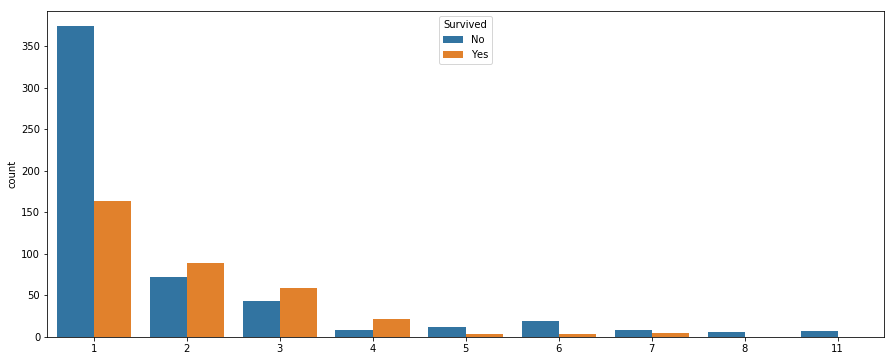

In [25]:
plt.figure(figsize=(15,6))
sns.countplot(titanic.Parch + titanic.SibSp + 1, hue=survived_annotated);

So we add family size as feature

In [26]:
titanic['Family_Size'] = titanic.Parch + titanic.SibSp + 1

#### Exploring Cabins

In [27]:
sum(titanic.Cabin.isna())

687

In [28]:
titanic.Cabin[~titanic.Cabin.isna()].sample(10)

PassengerId
790    B82 B84
292        B49
584        A10
725         E8
749        D30
391    B96 B98
461        E12
782        B20
738       B101
663        E58
Name: Cabin, dtype: object

Extracting cabin class from string with cabins or returing 'None'(as string) if Cabin has no value.

In [29]:
titanic['Cabin_Class'] = titanic.Cabin.apply(lambda x: 'None' if pd.isna(x) else re.search('^([A-Z])', x).group(0))

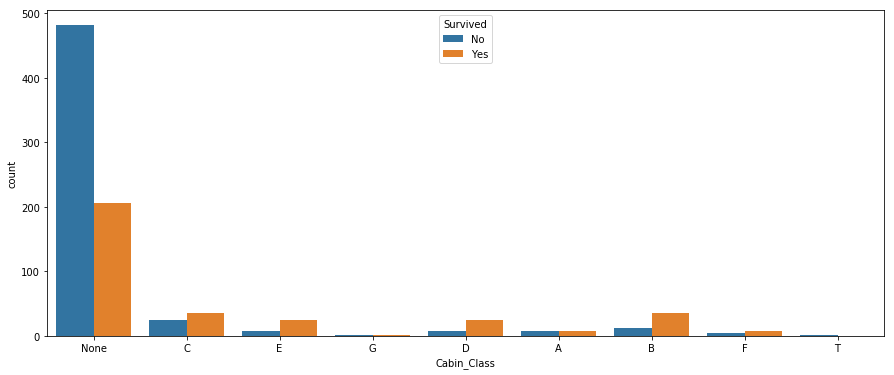

In [30]:
plt.figure(figsize=(15,6))
sns.countplot(titanic.Cabin_Class, hue=survived_annotated);

Encode cabin classes as features using LabelBinarizer

In [31]:
from sklearn.preprocessing import LabelBinarizer
cabin_bin = LabelBinarizer().fit(titanic.Cabin_Class)
cabin_bin.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'None', 'T'],
      dtype='<U4')

In [32]:
cabin_classes = pd.DataFrame(columns=cabin_bin.classes_, data=cabin_bin.transform(titanic.Cabin_Class))

In [33]:
cabin_classes.index

RangeIndex(start=0, stop=891, step=1)

In [34]:
titanic.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
           dtype='int64', name='PassengerId', length=891)

Reindex cabin_classes because of a index mismatch

In [35]:
cabin_classes.index = cabin_classes.index.reindex(range(1,892))[0]

Add cabin classes to the dataset

In [36]:
titanic = pd.concat([titanic, cabin_classes ], axis=1) 

Add separate feature for the count of cabins each person has on its name

In [37]:
cabin_count = titanic.Cabin.apply(lambda x: 0 if pd.isna(x) else x.count(' ') + 1)
cabin_count.value_counts()

0    687
1    180
2     16
3      6
4      2
Name: Cabin, dtype: int64

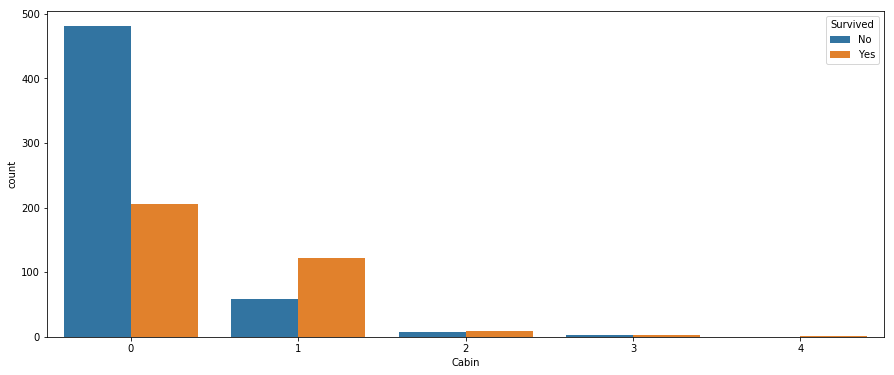

In [38]:
plt.figure(figsize=(15,6))
survived_annotated = titanic['Survived'].replace({1:'Yes', 0: 'No'})
sns.countplot(x=cabin_count, hue=survived_annotated);

In [39]:
titanic.describe().columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'IsMiss',
       'IsMaster', 'IsRev', 'IsRoyalty', 'IsOfficer', 'IsMr', 'IsMrs', 'Kid',
       'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS',
       'Family_Size', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'None', 'T'],
      dtype='object')

## Model selection

In [40]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'IsOfficer',
       'IsMr', 'IsMrs', 'IsMiss', 'IsRev', 'IsMaster', 'IsRoyalty', 'Kid',
       'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS',
       'Family_Size', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'None', 'T']]
Y = titanic.Survived

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

#### Random forrest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', max_depth=5, max_features='auto',
                            n_estimators=200, n_jobs=5, random_state=1)

In [43]:
from sklearn.model_selection import cross_val_score
rf_cvs = cross_val_score(rf, X, Y, cv = 10)

In [44]:
rf_cvs, rf_cvs.mean()

(array([ 0.83333333,  0.87777778,  0.78651685,  0.87640449,  0.84269663,
         0.80898876,  0.83146067,  0.78651685,  0.86516854,  0.85227273]),
 0.83611366473726023)

In [45]:
from sklearn.metrics import confusion_matrix
rf.fit(X_train, Y_train)
confusion_matrix(Y_test, rf.predict(X_test))

array([[117,  20],
       [ 22,  64]])

#### Logistic Regrgession

In [46]:
from sklearn.linear_model import LogisticRegression

rg = LogisticRegression(C=5)
rg_cvs = cross_val_score(rg, X, Y, cv = 10)

In [47]:
rg_cvs, rg_cvs.mean()

(array([ 0.8       ,  0.83333333,  0.78651685,  0.87640449,  0.82022472,
         0.79775281,  0.80898876,  0.80898876,  0.88764045,  0.86363636]),
 0.82834865509022815)

In [48]:
rg.fit(X_train, Y_train)
confusion_matrix(Y_test, rg.predict(X_test))

array([[116,  21],
       [ 19,  67]])

#### SVM

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

svm_pipe = make_pipeline(StandardScaler(), SVC(C=5, kernel='linear'))

In [50]:
svm_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [51]:
svm_pipe.score(X_train, Y_train), svm_pipe.score(X_test, Y_test)

(0.83233532934131738, 0.81614349775784756)

In [52]:
svm_cvs = cross_val_score(svm_pipe, X, Y, cv = 5)

In [53]:
svm_cvs, svm_cvs.mean()

(array([ 0.82122905,  0.81564246,  0.80898876,  0.76966292,  0.85875706]),
 0.81485605118400772)

In [54]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

gs_pipe = Pipeline([('sc', StandardScaler()), 
                     ('svm', SVC(kernel='linear'))])

/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [55]:
gs = GridSearchCV(gs_pipe, {'svm__C': [0.1, 0.5, 1, 3, 5, 10, 30]})

In [56]:
gs.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': [0.1, 0.5, 1, 3, 5, 10, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
gs.best_params_

{'svm__C': 1}

In [58]:
gs.score(X_train, Y_train), gs.score(X_test, Y_test)

(0.83233532934131738, 0.81614349775784756)

In [59]:
cross_val_score(gs, X, Y, cv = 5).mean()

0.81821421263379113

In [60]:
gs.fit(X_train, Y_train)
confusion_matrix(Y_test, gs.predict(X_test))

array([[117,  20],
       [ 21,  65]])

#### Neural Networks

In [61]:
from sklearn.neural_network import MLPClassifier

net = MLPClassifier(alpha=1, activation='relu', batch_size=300,
                    hidden_layer_sizes=(3,4), max_iter=5000, random_state=42)
net_cvs = cross_val_score(net, X, Y, cv=5)

In [62]:
net_cvs.mean()

0.81820786463658413

In [63]:
net.fit(X_train, Y_train)
confusion_matrix(Y_test, net.predict(X_test))

array([[121,  16],
       [ 25,  61]])

#### Voting classifier using the logistic regression, random forest and neural network
Internaly uses previous classifiers to vote and chooses the one with best score.

In [64]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('rg', rg), ('rf', rf), ('net', net)], voting='hard', weights=[5, 10, 2], n_jobs=3)
vc_cvs = cross_val_score(vc, X, Y, cv=5)

In [65]:
vc_cvs.mean()

0.83054872584347683

In [66]:
vc.fit(X_train, Y_train)
confusion_matrix(Y_test, vc.predict(X_test))

array([[117,  20],
       [ 22,  64]])

# Conclusion

All the classifiers used give roughly the same scores.

With all the fine tuning I went through, this are the best scores:

- Logistic Regrgession = 0.82834865509022815
- Random Forest = 0.83611366473726023
- SVC = 0.81614349775784756
- Neural Network = 0.81820786463658413
- Voting Classifier = 0.83054872584347683

The Random Forest gives the best score, although its not too much.

# Prepare test dataset

Loading test dataset

In [163]:
test_df = pd.read_csv('data/titanic/test.csv', index_col='PassengerId')

Making the same transformations as above

In [164]:
test_df['Title'] = test_df['Name'].str.extract('^.*, (.*?)\. .*$', expand = False)
test_df["Title"] = test_df["Title"].apply(titles_dict.get)

In [165]:
age = test_df.groupby('Title').Age.mean()

def restore_age(title, age):
    test_df.loc[test_df.Age.isnull() & (test_df.Title == title), 'Age'] = age[title]
    
for title in set(test_df.Title):
    restore_age(title, age)

In [166]:
def create_title_feature(title):
    test_df['Is' + title]      = (test_df.Title == title).astype(float)

for title in set(test_df.Title):
    create_title_feature(title)

In [167]:
test_df['Kid'] = (test_df.Age <= 18).astype('float')

In [168]:
test_df['IsMale']    = (test_df.Sex == 'male').astype(float)
test_df['IsFemale']  = (test_df.Sex == 'female').astype(float)

In [169]:
test_df['Family_Size'] = test_df.Parch + test_df.SibSp + 1

In [170]:
test_df.Embarked = test_df.Embarked.fillna('S')
test_df['EmbarkedC'] = (test_df.Embarked == 'C').astype(float)
test_df['EmbarkedQ'] = (test_df.Embarked == 'Q').astype(float)
test_df['EmbarkedS'] = (test_df.Embarked == 'S').astype(float)

In [171]:
test_df['Cabin_Class'] = test_df.Cabin.apply(lambda x: 'None' if pd.isna(x) else re.search('^([A-Z])', x).group(0))

In [172]:
cabin_classes = pd.DataFrame(columns=cabin_bin.classes_, data=cabin_bin.transform(test_df.Cabin_Class))

In [173]:
test_df.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [174]:
cabin_classes.index = cabin_classes.index.reindex(range(892,1310))[0]

In [176]:
test_df = pd.concat([test_df, cabin_classes ], axis=1)

In [177]:
test_df['Cabin_Count'] = test_df.Cabin.apply(lambda x: 0 if pd.isna(x) else x.count(' ') + 1)

In [178]:
test_df = test_df.drop(['Cabin'], axis=1)

In [179]:
test_x = test_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'IsOfficer',
       'IsMr', 'IsMrs', 'IsMiss', 'IsRev', 'IsMaster', 'IsRoyalty', 'Kid',
       'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS',
       'Family_Size', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'None', 'T']]

In [180]:
test_x.isna().sum()

Pclass         0
Age            0
SibSp          0
Parch          0
Fare           1
IsOfficer      0
IsMr           0
IsMrs          0
IsMiss         0
IsRev          0
IsMaster       0
IsRoyalty      0
Kid            0
IsMale         0
IsFemale       0
EmbarkedC      0
EmbarkedQ      0
EmbarkedS      0
Family_Size    0
A              0
B              0
C              0
D              0
E              0
F              0
G              0
None           0
T              0
dtype: int64

In [181]:
test_x['Fare'] = test_x.Fare.fillna(test_x.Fare.mean())
test_x.isna().sum()

/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
IsOfficer      0
IsMr           0
IsMrs          0
IsMiss         0
IsRev          0
IsMaster       0
IsRoyalty      0
Kid            0
IsMale         0
IsFemale       0
EmbarkedC      0
EmbarkedQ      0
EmbarkedS      0
Family_Size    0
A              0
B              0
C              0
D              0
E              0
F              0
G              0
None           0
T              0
dtype: int64

### Making prediction

In [187]:
prediction = vc.predict(test_x)

In [188]:
result = pd.DataFrame({"PassengerId": test_df.index, "Survived": prediction})

In [190]:
result.to_csv("data/titanic/submission.csv", sep=",", index=False)

## Score in Kaggle
![Score kaggle](data/score_kaggle_titanic.png)